In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DAMH_LTSSUD/plant-pathology-2020-fgvc7.zip

Archive:  /content/drive/MyDrive/APP-CQ18/plant-pathology-2020-fgvc7.zip
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflating: images/Test_1018.jpg    
  inflating: im

In [ ]:
import glob 
import cv2 
from google.colab.patches import cv2_imshow

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
test_dir = glob.glob('/content/images/Test*.jpg')  
train_dir = glob.glob('/content/images/Train*.jpg')  

train_dir = sorted(train_dir, key = lambda x: (len(x), x))
test_dir = sorted(test_dir, key = lambda x: (len(x), x))

test = [] 
train = [] 
scale = 0.5

for f in test_dir: 
  img = cv2.imread(f)
  width = int(img.shape[1] * scale)
  height = int(img.shape[0] * scale)
  dim = (width, height)
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  test.append(resized) 

for f in train_dir: 
  img = cv2.imread(f)
  width = int(img.shape[1] * scale)
  height = int(img.shape[0] * scale)
  dim = (width, height)
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  train.append(resized)

In [ ]:
import numpy as np

def resize(image, scale_height, scale_width): # resize image function with scale is in range (0, 1)
  height, width, channel = image.shape[:] # get height, width, channel in shape of image

  new_height = int(height * scale_height) # new height after height scaled
  new_width = int(width * scale_width) # new width after width scaled

  array_channel = []
  array_height = []
  array_width = []

  for i in range(channel):
    array_channel.append(np.float64(0))
  for j in range(new_width):
    array_width.append(array_channel)
  for k in range(new_height):
    array_height.append(array_width)

  new_image = np.array(array_height)
  
  for i in range(new_height): # iterate vertical pixel in new height
   for j in range(new_width): # iterate horizontal pixel in new width
    new_image[i, j] = image[int(i / scale_height), int(j / scale_width)] # root image has bigger size than new image, pixels in root image
    # have smaller size than new image. Because scale is in range (0, 1) so that pixels divide to scale

  return new_image # return new image

In [ ]:
def gray(image, radius): # gray image function
  height, width, channel = image.shape[:] # get height, width, channel in shape of image 

  array_channel = []
  array_height = []
  array_width = []

  for i in range(channel):
    array_channel.append(np.float64(0))
  for j in range(width):
    array_width.append(array_channel)
  for k in range(height):
    array_height.append(array_width)

  new_image = np.array(array_height)

  for i in range(height): # iterate vertical pixel in height
   for j in range(width): # iterate horizontal pixel in width
 
    temp = (np.float64(image[i, j][0]) * np.float64(image[i, j][1]) * np.float64(image[i, j][2])) ** (1 / 3) # calculate temp value

    new_image[i, j][0] = temp / (radius ** (1 / 2))  # set red pixels to temp value
    new_image[i, j][1] = temp / (radius ** (1 / 2)) # set green pixels to temp value
    new_image[i, j][2] = temp / (radius ** (1 / 2)) # set blue pixels to temp value
    # convert root image to gray image because red, green, blue pixels are equal
    
  return new_image # return new image

In [ ]:
def tuple_add(a, b): # add two tuples function
    return (a[0] + b[0], a[1] + b[1], a[2] + b[2])

def tuple_multiple(a, value): # multiple tuple by a scalar function
    return (a[0] * value, a[1] * value, a[2] * value)

In [ ]:
from math import exp, pi

def gaussian(x, radius, sigma): # calculate gaussian value function
  return (1 / (2 * pi * sigma ** 2) ** (1 / 2)) * (exp((-1 / 2) * ((x - radius) / sigma) ** 2))

In [ ]:
def gaussian_kernel(radius, sigma): # calculate gaussian kernel filter function
  hkernel = np.array([gaussian(x, radius, sigma) for x in range(2 * radius + 1)])
  vkernel = np.array([x for x in hkernel])
  kernel = np.empty((len(vkernel), len(hkernel)))

  for i, xv in enumerate(vkernel):
    for j, xh in enumerate(hkernel):
      kernel[i, j] = xv * xh

  kernel_sum = np.sum(kernel)
    
  kernel /= kernel_sum
  return kernel

In [ ]:
def apply_kernel(image, pixel_height, pixel_width, radius, sigma): # apply gaussian kernel filter for root image function
  
  gaussian_matrix = gaussian_kernel(radius, sigma)
  height, width = image.shape[:2]
  col = (np.float64(0), np.float64(0), np.float64(0))
  weight_sum = np.float64(0)

  for i in range(2 * radius + 1):
    for j in range(2 * radius + 1):
      new_height = pixel_height + i - 2
      new_width = pixel_width + j - 2
      if new_height >= 0 and new_height <= height - 1 and new_width >= 0 and new_width <= width - 1:
        element_value = np.float64(gaussian_matrix[i,j]) * 255
        col = tuple_add(col, tuple_multiple(image[new_height, new_width], element_value))
        weight_sum += element_value

  return (col[0] / weight_sum, col[1] / weight_sum, col[2] / weight_sum)

In [ ]:
def blur(image, radius, sigma): # blur image function
  height, width, channel = image.shape[:] # get height, width, channel in shape of image 
  
  array_channel = []
  array_height = []
  array_width = []

  for i in range(channel):
    array_channel.append(np.float64(0))
  for j in range(width):
    array_width.append(array_channel)
  for k in range(height):
    array_height.append(array_width)

  new_image = np.array(array_height)

  for i in range(height): # iterate vertical pixel in height
    for j in range(width): # iterate horizontal pixel in width
      new_image[i, j] = apply_kernel(image, i, j, radius, sigma) # convert root image to blur image

  return new_image # return new image

resize(hình ảnh RGB đầu vào, tham số thay đổi kích thước chiều cao, tham số thay đổi kích thước chiều rộng)

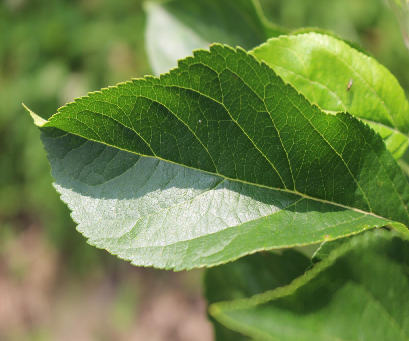

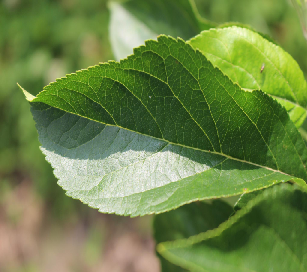

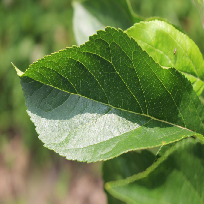

In [ ]:
cv2_imshow(resize(train[99], 0.5, 0.4))
cv2_imshow(resize(train[99], 0.4, 0.3))
cv2_imshow(resize(train[99], 0.3, 0.2))

gray(hình ảnh RGB đầu vào, kích thước hạt nhân làm ảnh xám)

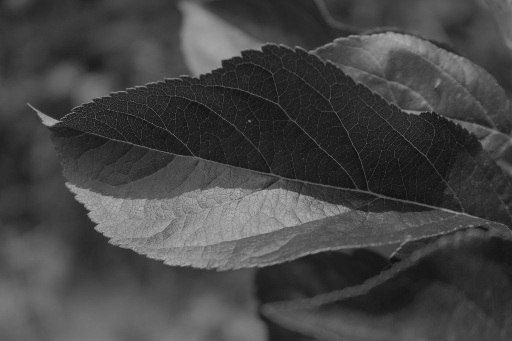

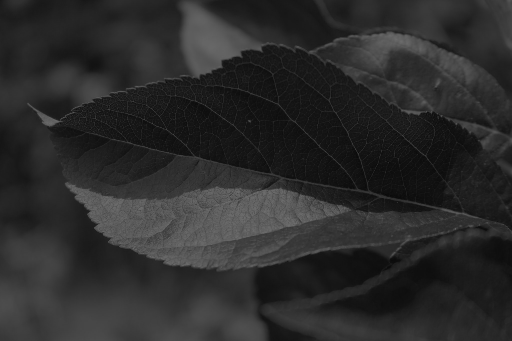

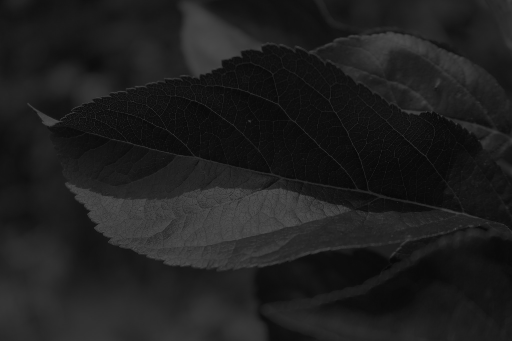

In [ ]:
cv2_imshow(resize(gray(train[99], 2), 0.5, 0.5))
cv2_imshow(resize(gray(train[99], 5), 0.5, 0.5))
cv2_imshow(resize(gray(train[99], 10), 0.5, 0.5))

blur(hình ảnh RGB đầu vào, kích thước hạt nhân làm ảnh mờ, sigma làm mờ)

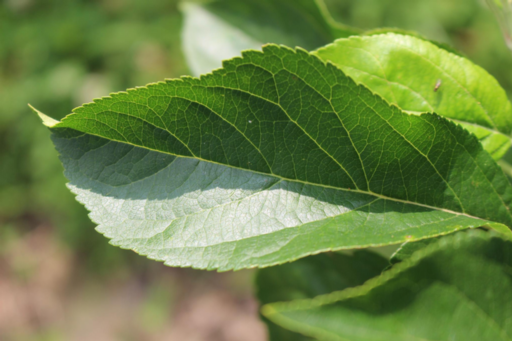

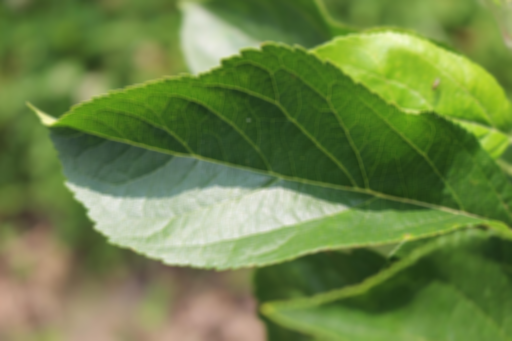

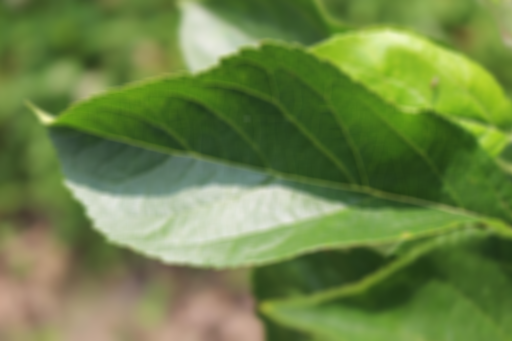

In [14]:
#b = cv2.GaussianBlur(train[99], (5,5), 0)
cv2_imshow(resize(blur(train[99], 1, 50), 0.5, 0.5))
cv2_imshow(resize(blur(train[99], 4, 25), 0.5, 0.5))
cv2_imshow(resize(blur(train[99], 7, 10), 0.5, 0.5))

In [15]:
cv = cv2.GaussianBlur(train[100], (1, 1), 10)
func = blur(train[100], 1, 10)

In [ ]:
# np.mean(np.abs(np.subtract(d, c)))
np.mean(np.abs(func - cv))

In [17]:
from numba import jit, njit, prange

In [18]:
@jit
def ta(a, b): # add two tuples function
    return (a[0] + b[0], a[1] + b[1], a[2] + b[2])
    
@jit
def tm(a, val): # multiple tuple by a scalar function
    return (a[0] * val, a[1] * val, a[2] * val)

In [19]:
@jit
def g(x, radius, sigma): # calculate gaussian value function
  return (1 / (2 * pi * sigma ** 2) ** (1 / 2)) * (exp((-1 / 2) * ((x - radius) / sigma) ** 2))

In [20]:
@jit
def gk(radius, sigma): # calculate gaussian kernel filter function
  hkernel = np.array([g(x, radius, sigma) for x in range(2 * radius + 1)])
  vkernel = np.array([x for x in hkernel])
  kernel = np.empty((len(vkernel), len(hkernel)))

  for i, xv in enumerate(vkernel):
    for j, xh in enumerate(hkernel):
      kernel[i, j] = xv * xh

  kernel_sum = np.sum(kernel)
    
  kernel /= kernel_sum
  return kernel

In [21]:
@jit
def ak(image, pixel_height, pixel_width, radius, sigma): # apply kernel for root image function
  
  gaussian_matrix = gk(radius, sigma)
  height, width = image.shape[:2]
  col = (np.float64(0), np.float64(0), np.float64(0))
  weight_sum = np.float64(0)

  for i in range(2 * radius + 1):
    for j in range(2 * radius + 1):
      new_height = pixel_height + i - 2
      new_width = pixel_width + j - 2
      if new_height >= 0 and new_height <= height - 1 and new_width >= 0 and new_width <= width - 1:
        element_value = np.float64(gaussian_matrix[i,j]) * 255
        col = ta(col, tm(image[new_height, new_width], element_value))
        weight_sum += element_value

  return (col[0] / weight_sum, col[1] / weight_sum, col[2] / weight_sum)

In [22]:
@jit
def blur_jit(image, radius, sigma): # blur image function
  height, width, channel = image.shape[:] # get height, width, channel in shape of image 
  
  array_channel = []
  array_height = []
  array_width = []

  for i in range(channel):
    array_channel.append(np.float64(0))
  for j in range(width):
    array_width.append(array_channel)
  for k in range(height):
    array_height.append(array_width)

  new_image = np.array(array_height)

  for i in range(height): # iterate vertical pixel in height
    for j in range(width): # iterate horizontal pixel in width
      new_image[i, j] = ak(image, i, j, radius, sigma) # convert root image to blur image

  return new_image # return new image

In [23]:
@jit
def resize_jit(image, scale_height, scale_width): # resize image function with scale is in range (0, 1)
  height, width, channel = image.shape[:] # get height, width, channel in shape of image

  new_height = int(height * scale_height) # new height after height scaled
  new_width = int(width * scale_width) # new width after width scaled

  array_channel = []
  array_height = []
  array_width = []

  for i in range(channel):
    array_channel.append(np.float64(0))
  for j in range(new_width):
    array_width.append(array_channel)
  for k in range(new_height):
    array_height.append(array_width)

  new_image = np.array(array_height)
  
  for i in range(new_height): # iterate vertical pixel in new height
   for j in range(new_width): # iterate horizontal pixel in new width
    new_image[i, j] = image[int(i / scale_height), int(j / scale_width)] # root image has bigger size than new image, pixels in root image
    # have smaller size than new image. Because scale is in range (0, 1) so that pixels divide to scale

  return new_image # return new image

In [24]:
@jit
def gray_jit(image, radius): # gray image function
  height, width, channel = image.shape[:] # get height, width, channel in shape of image 

  array_channel = []
  array_height = []
  array_width = []

  for i in range(channel):
    array_channel.append(np.float64(0))
  for j in range(width):
    array_width.append(array_channel)
  for k in range(height):
    array_height.append(array_width)

  new_image = np.array(array_height)

  for i in range(height): # iterate vertical pixel in height
   for j in range(width): # iterate horizontal pixel in width
 
    temp = (np.float64(image[i, j][0]) * np.float64(image[i, j][1]) * np.float64(image[i, j][2])) ** (1 / 3) # calculate temp value

    new_image[i, j][0] = temp / (radius ** (1 / 2))  # set red pixels to temp value
    new_image[i, j][1] = temp / (radius ** (1 / 2)) # set green pixels to temp value
    new_image[i, j][2] = temp / (radius ** (1 / 2)) # set blue pixels to temp value
    # convert root image to gray image because red, green, blue pixels are equal
    
  return new_image # return new image

In [33]:
%%time
a = resize_jit(test[500], 0.45, 0.6)

CPU times: user 5.69 ms, sys: 0 ns, total: 5.69 ms
Wall time: 5.66 ms


In [34]:
%%time
b = gray_jit(test[500], 8)

CPU times: user 45.1 ms, sys: 5 ms, total: 50.1 ms
Wall time: 49.9 ms


In [35]:
%%time
c = blur_jit(test[500], 8, 20)

CPU times: user 1.68 s, sys: 6.01 ms, total: 1.68 s
Wall time: 1.67 s


In [28]:
from numba import cuda

In [29]:
@cuda.jit
def resize_cuda(image, scale_height, scale_width, new_image):
  row, col = cuda.grid(2)

  if row < image.shape[0] and col < image.shape[1]:
    new_image[row, col] = image[int(row / scale_height), int(col / scale_width)]

  return new_image

In [30]:
@cuda.jit
def gray_cuda(image, radius, new_image):
  row, col = cuda.grid(2)
  if row < image.shape[0] and col < image.shape[1]:
    temp = (new_image[row,col][0] * new_image[row,col][1] * new_image[row,col][2]) ** (1/3)
    new_image[row, col][0] = temp / (radius ** (1 / 2))
    new_image[row, col][1] = temp / (radius ** (1 / 2))
    new_image[row, col][2] = temp / (radius ** (1 / 2))

In [31]:
import math

threadsperblock = (8, 8)
blockspergrid_x = math.ceil(train[99].shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(train[99].shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

resize_image = np.empty([int(train[99].shape[0] * 0.5), int(train[99].shape[1] * 0.4), train[99].shape[2]])

In [32]:
d = resize_cuda[blockspergrid, threadsperblock](train[99], 0.6, 0.3, resize_image)

TypingError: ignored